# Multi-armed bandits: LinUCB and MLinUCB

This notebook includes the implementation of LinUCB and MLinUCB.

In [1]:
import numpy as np
from abc import ABC, abstractmethod

# Type annotations
from numpy import ndarray
from numpy.random import Generator
from typing import List, Deque, Optional, Tuple

from sklearn.cluster import KMeans                 
from sklearn.linear_model import LogisticRegression
from collections import deque                      
from scipy.stats import multivariate_normal        
import matplotlib.pyplot as plt                    

The base `MAB` class below defines a common interface for a contextual multi-armed bandit.

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
        
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, rng: Optional[Generator] = None) -> None:
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        self.rng = np.random.default_rng(rng)
        
    @abstractmethod
    def play(self, context: ndarray) -> int:
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        
    @abstractmethod
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None.
            
        reward : float, optional
            Reward received from the arm. If None, the reward is missing.
        """
        if arm >= self.n_arms or arm < 0:
            raise ValueError("`arm` must be in the range "
                             "[0, {}]".format(self.n_arms - 1))

In [3]:
def eval(mab: MAB, arms: ndarray, rewards: ndarray, contexts: ndarray, 
                 n_rounds: Optional[int] = None) -> ndarray:
    arms = np.asarray(arms)
    rewards = np.asarray(rewards)
    contexts = np.asarray(contexts)
    matched_ctr = 0
    matched_ids = list()
    for i in range(arms.size):
        if matched_ctr >= n_rounds:
            break
        arm_id = mab.play(contexts[i])
        if arm_id == arms[i]:
            reward = None if np.isnan(rewards[i]) else rewards[i]
            mab.update(arm_id, contexts[i], reward)
            matched_ctr += 1
            matched_ids.append(i)
    
    matched_ids = np.array(matched_ids)
    return rewards[matched_ids], matched_ids

In [4]:
rng = np.random.default_rng(12345)  # Random generator used throughout

# Define additional static functions/variables here, if required
data = np.loadtxt('dataset.txt', dtype=float)

## LinUCB

In [5]:
class LinUCB(MAB):
    """LinUCB

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, alpha: float, 
                 rng: Optional[Generator] = None) -> None:
        ... # implement or remove this method
        MAB.__init__(self, n_arms, rng)
        self.n_dims = n_dims
        self.alpha = alpha
        
        # Initialise n_arms d-dimensional identity matrix As and n_arms d-dimensional zero vector cs
        self.As = np.array([np.identity(n_dims) for i in range(n_arms)])
        self.cs = np.array([np.zeros([n_dims,1]) for i in range(n_arms)])
        
    def play(self, context: ndarray) -> int:
        ... # implement or remove this method
        highest_ucb = -1
        candidate_arms = []
        
        for arm_index in range(self.n_arms):
            # calculate ucb
            A = self.As[arm_index]
            c = self.cs[arm_index]
            x = context[arm_index][:, np.newaxis] # to column vector
            
            A_inv = np.linalg.inv(A)
            theta_hat = np.dot(A_inv, c)
            
            p = np.dot(theta_hat.T, x) + self.alpha * np.sqrt(np.dot(x.T, np.dot(A_inv,x)))
            if p > highest_ucb:
                highest_ucb = p
                candidate_arms = [arm_index]
            elif p == highest_ucb:
                candidate_arms.append(arm_index)
        return rng.choice(candidate_arms)
        
    
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        ... # implement or remove this method
        if reward is None:
            return
        x = context[arm][:, np.newaxis] # to column vector
        self.As[arm] += np.dot(x, x.T)
        self.cs[arm] += reward * x
        

In [6]:
# Load dataset here
arms = data[:, 0]
rewards = data[:,1]
contexts = data[:,3:103].reshape(data.shape[0], 10, 10)

In [7]:
mab = LinUCB(10, 10, 1.0, rng)
LinUCB_rewards, _ = eval(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(LinUCB_rewards))

LinUCB average reward 0.53


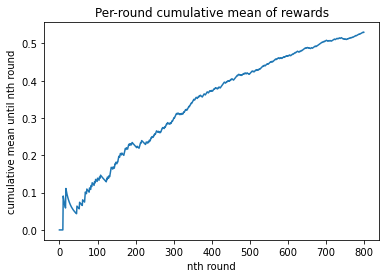

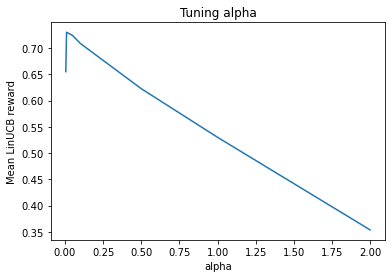

In [8]:
# Use additional cells here for experimentation
cumulative = np.cumsum(LinUCB_rewards)
for i in range(len(cumulative)):
    cumulative[i] =  cumulative[i] / (i + 1)

plt.figure(0)
plt.xlabel('nth round')
plt.ylabel('cumulative mean until nth round')
plt.title('Per-round cumulative mean of rewards')
plt.plot(range(len(cumulative)), cumulative)

alpha_grid = [0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
rewards_mean_tuning = []
for alpha_tuning in alpha_grid:
    mab = LinUCB(10, 10, alpha_tuning, rng)
    LinUCB_rewards, a = eval(mab, arms, rewards, contexts, 800)
    rewards_mean_tuning.append(np.mean(LinUCB_rewards))
    
plt.figure(1)
plt.xlabel('alpha')
plt.ylabel('Mean LinUCB reward')
plt.title('Tuning alpha')
plt.plot(alpha_grid, rewards_mean_tuning)

# The value of alpha that gives the best mean rewards value is 0.01

## MLinUCB

In [9]:
class MLinUCB(MAB):
    """MLinUCB"""
    def __init__(self, n_arms: int, n_dims: int, alpha: float, N: int, m: int, 
                 rng: Optional[Generator] = None) -> None:
        ... # implement or remove this method
        MAB.__init__(self, n_arms, rng)
        self.n_dims = n_dims
        self.alpha = alpha
        self.N = N
        self.m = m
        
        # Initialise n_arms d-dimensional identity matrix As and n_arms d-dimensional zero vector cs
        self.As = np.array([np.identity(n_dims) for i in range(n_arms)])
        self.cs = np.array([np.zeros([n_dims,1]) for i in range(n_arms)])
        
        # Context history grouped by arms, updated up to the t step.
        self.updated_contexts = dict()
        
    def play(self, context: ndarray) -> int:
        ... # implement or remove this method
        max_ucb = -1
        candidat_arms = []
        for arm_index in range(self.n_arms):
            # calculate ucb
            A = self.As[arm_index]
            c = self.cs[arm_index]
            x = context[arm_index][:, np.newaxis] # to column vector
            A_inv = np.linalg.inv(A)
            theta_hat = np.dot(A_inv, c)
            p = np.dot(theta_hat.T, x) + self.alpha * np.sqrt(np.dot(x.T, np.dot(A_inv,x)))
            if p > max_ucb:
                max_ucb = p
                candidate_arms = [arm_index]
            elif p == max_ucb:
                candidate_arms.append(arm_index)
        return rng.choice(candidate_arms)
    
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        ... # implement or remove this method
        x = context[arm][:, np.newaxis] # to column vector
        self.As[arm] += np.dot(x, x.T)
        if reward is None:
            if arm not in self.updated_contexts:
                # no arm pulled context in the context history to compare.
                return
            
            arm_contexts = np.array([action['context'] for action in self.updated_contexts[arm]])
            arm_rewards = np.array([action['reward'] for action in self.updated_contexts[arm]])
            
            n_clusters = min(self.N, arm_contexts.shape[0])
            
            random_state = np.random.RandomState(rng.bit_generator)
            kmeans = KMeans(n_clusters = n_clusters, random_state=random_state).fit(arm_contexts)
            
            # Euclidean distance of current context to all centroids
            dists = np.array([np.linalg.norm(context.flatten() - centroid) for centroid in kmeans.cluster_centers_])
            m_closest_centroids = dists.argsort()[:min(self.m, arm_contexts.shape[0])]
            
            sum_rj_bar_divide_dist = 0 # g(x) numerator
            sum_dist_inv = 0.1 # g(x) denominator
            
            for j in m_closest_centroids:
                # filter by clusters
                indx = np.where(kmeans.labels_ == j)
                rj_bar = sum(arm_rewards[indx]) / len(arm_rewards[indx])
                sum_rj_bar_divide_dist += rj_bar / (0.1 + dists[j])
                sum_dist_inv += 1 / (0.1 + dists[j])
                
            reward = sum_rj_bar_divide_dist / sum_dist_inv
        else:
            # Update the current context history with existed reward
            if arm not in self.updated_contexts:
                self.updated_contexts[arm] = []
            self.updated_contexts[arm].append({'reward': reward, 'context': np.array(context.flatten())})
            
        self.cs[arm] += reward * x

In [10]:
# Define rewards_missing here - the rewards array from above where missing values are represented as np.nan
missing_flags = data[:, 2]
rewards_missing = np.copy(rewards)
rewards_missing[np.where(missing_flags == 0)] = np.nan

In [11]:
mab = MLinUCB(10, 10, 1.0, 10, 3, rng)
MLinUCB_rewards, MLinUCB_ids = eval(mab, arms, rewards_missing, contexts, 800)
print('MLinUCB average reward', np.mean(rewards[MLinUCB_ids]))

mab = LinUCB(10, 10, 1.0, rng)
LinUCB_rewards, LinUCB_ids = eval(mab, arms, rewards_missing, contexts, 800)
print('LinUCB average reward', np.mean(rewards[LinUCB_ids]))

MLinUCB average reward 0.4625
LinUCB average reward 0.39


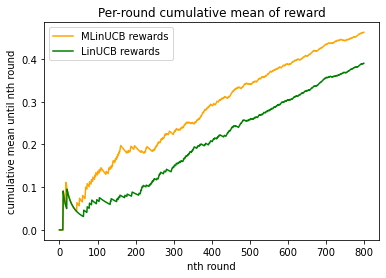

The best rewards mean: 0.65125 achieved by alpha = 0.1 , N = 8 , m = 3


In [12]:
MLinUCB_rewards_cumulative = np.nancumsum(rewards[MLinUCB_ids])
for i in range(len(MLinUCB_rewards_cumulative)):
    MLinUCB_rewards_cumulative[i] =  MLinUCB_rewards_cumulative[i] / (i + 1)
    
LinUCB_rewards_cumulative = np.nancumsum(rewards[LinUCB_ids])
for i in range(len(LinUCB_rewards_cumulative)):
    LinUCB_rewards_cumulative[i] = LinUCB_rewards_cumulative[i] / (i + 1)

plt.plot(range(len(MLinUCB_rewards_cumulative)), MLinUCB_rewards_cumulative, color ='orange', markersize = 12, label ='MLinUCB rewards')
plt.plot(range(len(LinUCB_rewards_cumulative)), LinUCB_rewards_cumulative, color ='green', markersize = 12, label ='LinUCB rewards')
plt.xlabel('nth round')
plt.ylabel('cumulative mean until nth round')
plt.title('Per-round cumulative mean of reward')
plt.legend()
plt.show()

# Tuning alpha, N and m by grid search
alpha_grid = [0.01, 0.1, 0.5, 1]
N_grid = range(8, 11, 1)
m_grid = range(3, 6, 1)

best_mean_MLinUCB_rewards = -1
best_alpha = best_N = best_m = -1

for x in range(len(alpha_grid)):
    for y in range(len(N_grid)):
        for z in range(len(m_grid)):
            alpha_tuning = alpha_grid[x]
            N_tuning = N_grid[y]
            m_tuning = m_grid[z]
            mab = MLinUCB(10, 10, alpha_tuning, N_tuning, m_tuning, rng)
            MLinUCB_rewards, MLinUCB_ids = eval(mab, arms, rewards_missing, contexts, 800)
            if np.mean(rewards[MLinUCB_ids]) > best_mean_MLinUCB_rewards:
                best_mean_MLinUCB_rewards = np.mean(rewards[MLinUCB_ids])
                best_alpha, best_N, best_m = alpha_grid[x], N_grid[y], m_grid[z]

# Output the values of alpha, N and m that give the best result of rewards mean using grid search
print('The best rewards mean:', best_mean_MLinUCB_rewards, 'achieved by alpha =', best_alpha, ', N =', best_N, ', m =', best_m)